In [1]:
from pickle import load
from math import ceil
from keras import Model
import keras
from keras.applications import ResNet152V2
from keras.layers import Input, Dense, LSTM, Embedding, Add, Dropout
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

from functions.dataset_loading import load_flicker8k_split
from functions.text_processing import create_vocab_mappings
from functions.training import data_generator
from functions.model_evaluation import evaluate_captions

keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080, compute capability 8.6


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
SEQ_LENGTH = 20
HIDDEN_DIM = 256
EMBED_DIM = 300
EPOCHS = 100
DROPOUT = 0.4
BATCH_SIZE = 256 # 1024 for training with pooled features
VOCAB_SIZE = 4096

In [3]:
DIR = 'preprocessed_data/flicker8k/'

with open(DIR + 'caption_map.pkl', 'rb') as file:
    caption_map = load(file)
    
with open(DIR + 'avg_feature_map.pkl', 'rb') as file:
    feature_map = load(file)

with open('preprocessed_data/vocab.pkl', 'rb') as file:
    vocab = load(file)
    
VOCAB_SIZE = len(vocab)
    
with open('preprocessed_data/embedding_matrix.pkl', 'rb') as file:
    embedding_matrix = load(file)
    
EMBED_DIM = embedding_matrix.shape[1]

word_to_idx, idx_to_word = create_vocab_mappings(vocab)
train_images, val_images, test_images = load_flicker8k_split()

STEPS = ceil(len(train_images) * 5 / BATCH_SIZE)
VAL_STEPS = ceil(len(val_images) * 5 / BATCH_SIZE)

word_to_idx, idx_to_word = create_vocab_mappings(vocab)

train_data = data_generator (train_images, caption_map, feature_map, BATCH_SIZE)
val_data = data_generator(val_images, caption_map, feature_map, BATCH_SIZE)

# Model 

In [4]:
embedding_layer = Embedding(
    VOCAB_SIZE,
    EMBED_DIM,
    input_length=SEQ_LENGTH,
    trainable=False,
    weights=[embedding_matrix],
    name='sequence_embedding'
)

In [5]:
# Image layers
image_input = Input(shape=(1536), name='image_input')
image_dropout = Dropout(DROPOUT, name='image_dropout')(image_input)
image_dense = Dense(HIDDEN_DIM, activation = 'relu', name='image_dense')(image_dropout)

# Sequence layers
sequence_input = Input(shape=(SEQ_LENGTH,), name='sequence_input')
sequence_embedding = embedding_layer(sequence_input)
embedding_dropout = Dropout(DROPOUT, name='emedding_dropout')(sequence_embedding)
lstm = LSTM(HIDDEN_DIM, return_sequences=True) (embedding_dropout)

# Combine image and sequence
merging_layer = Add()([image_dense, lstm])
mergerd_dropout = Dropout(.4)(merging_layer)

# Prediction layers
dense = Dense(512, activation ='relu')(merging_layer)
dropout = Dropout(DROPOUT)(dense)
output = Dense(VOCAB_SIZE , activation ='softmax')(mergerd_dropout)

# Combining the layers to 
decoder = Model(inputs = [image_input, sequence_input] , outputs = output )
decoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence_input (InputLayer)    [(None, 20)]         0           []                               
                                                                                                  
 image_input (InputLayer)       [(None, 1536)]       0           []                               
                                                                                                  
 sequence_embedding (Embedding)  (None, 20, 300)     1228800     ['sequence_input[0][0]']         
                                                                                                  
 image_dropout (Dropout)        (None, 1536)         0           ['image_input[0][0]']            
                                                                                              

In [6]:
# plot_model(lstm_decoder, show_shapes = True)

# Training

In [7]:
optimizer = Adam(learning_rate=0.001)

loss = SparseCategoricalCrossentropy()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

decoder.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

training = decoder.fit(
    train_data,
    epochs=EPOCHS,
    steps_per_epoch=STEPS,
    validation_data=val_data,
    validation_steps=VAL_STEPS,
    callbacks= [early_stopping],
    verbose=1
)

Epoch 1/100
118/118 [==============================] - 12s 51ms/step - loss: 3.4268 - accuracy: 0.4789 - val_loss: 2.7480 - val_accuracy: 0.5439
Epoch 2/100
118/118 [==============================] - 2s 18ms/step - loss: 2.5218 - accuracy: 0.5641 - val_loss: 2.3164 - val_accuracy: 0.5849
Epoch 3/100
118/118 [==============================] - 2s 19ms/step - loss: 2.2389 - accuracy: 0.5886 - val_loss: 2.1195 - val_accuracy: 0.6020
Epoch 4/100
118/118 [==============================] - 2s 19ms/step - loss: 2.0923 - accuracy: 0.6002 - val_loss: 2.0233 - val_accuracy: 0.6108
Epoch 5/100
118/118 [==============================] - 2s 18ms/step - loss: 1.9978 - accuracy: 0.6078 - val_loss: 1.9673 - val_accuracy: 0.6172
Epoch 6/100
118/118 [==============================] - 2s 19ms/step - loss: 1.9304 - accuracy: 0.6131 - val_loss: 1.9557 - val_accuracy: 0.6153
Epoch 7/100
118/118 [==============================] - 2s 18ms/step - loss: 1.8749 - accuracy: 0.6173 - val_loss: 1.8865 - val_accuracy

In [8]:
# lstm_decoder.save('models/lstm_decoder_for_cnn_encoder.keras')

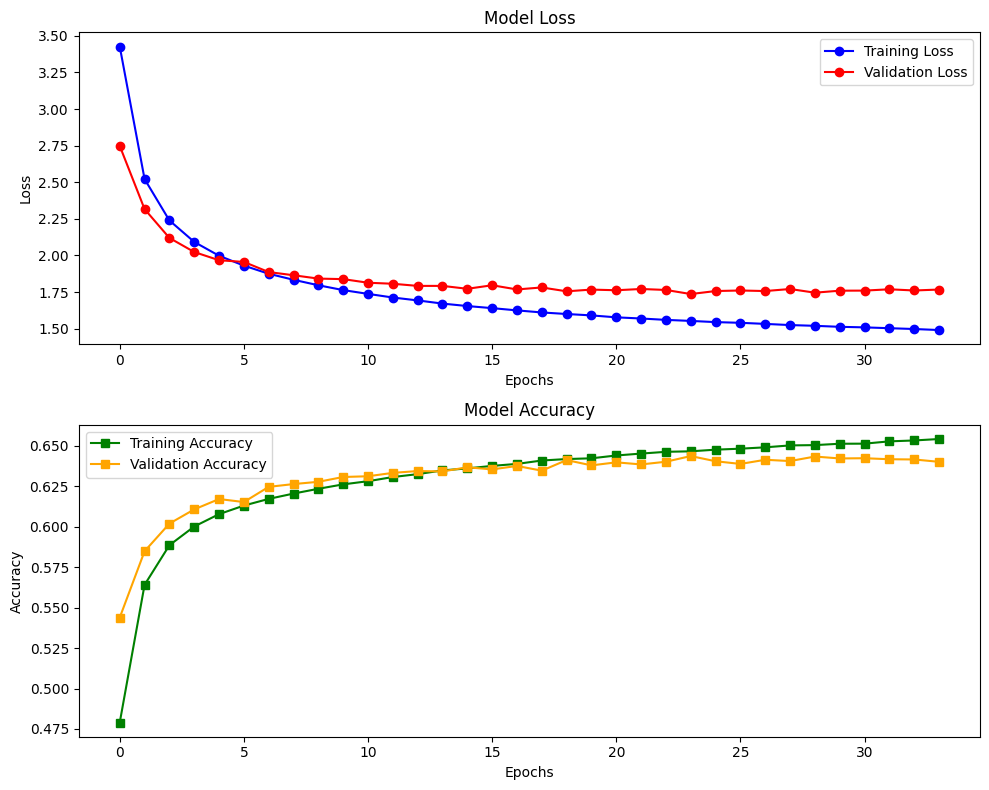

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plotting Loss
axes[0].plot(training.history['loss'], marker='o', color='b', label='Training Loss')
axes[0].plot(training.history['val_loss'], marker='o', color='r', label='Validation Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plotting Accuracy
axes[1].plot(training.history['accuracy'], marker='s', color='g', label='Training Accuracy')
axes[1].plot(training.history['val_accuracy'], marker='s', color='orange', label='Validation Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [1]:
from functions.model_evaluation import generate_and_evaluate_caption
from functions.image_processing import display_image
from numpy.random import choice 

test_image = choice(val_images)
test_features = feature_map[test_image]
true_captions = caption_map[test_image]

display_image('datasets/flicker8k/flicker8k_images/', test_image)

caption, true_captions, bleu, meteor = generate_and_evaluate_caption(decoder, test_features, true_captions, idx_to_word, SEQ_LENGTH)
print(caption, ' ', meteor) 

NameError: name 'val_images' is not defined

In [ ]:
validation_score = evaluate_captions(val_images, caption_map, feature_map, idx_to_word, decoder, SEQ_LENGTH)
print(validation_score)

Vocab size = 2000
1. Training with 43 epochs 
    - BLEU1 = 0.5645087347652957
    - BLUE2 = 0.37314058036164954
    - BLUE3 = 0.23647034587722704
    - BLUE4 = 0.15829620808385458
    - METEOR = 0.37246725183805224
    
2. Training with 33 epochs 
    - BLEU1 = 0.5637795494562754
    - BLUE2 = 0.37517793166503066
    - BLUE3 = 0.23943555567568464
    - BLUE4 = 0.1615831701540679
    - METEOR = 0.36669583556435564

3. Training with 46 epochs 
    - BLEU1 = 0.5607791708924014
    - BLUE2 = 0.3680730111537539
    - BLUE3 = 0.2328928767781985
    - BLUE4 = 0.15578114237968402
    - METEOR = 0.3708387771102537
4. Training with 37 epochs 
    - BLEU1 = 0.5623996822131478
    - BLUE2 = 0.3694518309564606
    - BLUE3 = 0.2352771941300196
    - BLUE4 = 0.1585337835148738
    - METEOR = 0.36326712535646494